This notebook aims to further preprocess the subreddit text data and subsequently model the data to observe whether or not the models utilized accurately classify each post as either a legal advice subrreddit or a  casual conversation subeddit. 

* __Part 4a:__ Stemming and Lemmatizing
* __Part 4b:__  Modeling; Logistic Regression and Random Forest

__Imports__

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

import spacy

import nltk
from nltk.stem.porter import *
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics

__Reading in the Data__

In [2]:
reddit= pd.read_csv('./data/cleaned_reddit.csv')
reddit.head()

,Unnamed: 0,index,author,created_utc,full_link,id,num_comments,retrieved_on,selftext,subreddit,title,url,posts,word_count
0,1,1,banksnosons,1629570605,https://www.reddit.com/r/legaladvice/comments/...,p8wn7t,3,1629577686,What can I do? My old neighbor witnessed the p...,1,"Package delivered to old residence, not being ...",https://www.reddit.com/r/legaladvice/comments/...,"package delivered to old residence, not being ...",70
1,2,2,Hangman_Matt,1629570478,https://www.reddit.com/r/legaladvice/comments/...,p8wlv0,12,1629577576,Does use of obscene language in school fall un...,1,First Ammendment rights and Schools,https://www.reddit.com/r/legaladvice/comments/...,first ammendment rights and schools.does use o...,216
2,3,3,Throwawaaaaaay526289,1629570313,https://www.reddit.com/r/legaladvice/comments/...,p8wk5r,4,1629577433,Basically what the title says. I've never been...,1,Virginia - If my employer only shows a set amo...,https://www.reddit.com/r/legaladvice/comments/...,virginia if my employer only shows a set amo...,206
3,4,4,unholychalice,1629570134,https://www.reddit.com/r/legaladvice/comments/...,p8wi9h,3,1629577281,Can I record with video and audio from my porc...,1,Can I record visual and audio from my front po...,https://www.reddit.com/r/legaladvice/comments/...,can i record visual and audio from my front po...,100
4,6,6,opsboop,1629569971,https://www.reddit.com/r/legaladvice/comments/...,p8wgjm,0,1629577141,"We live on a quiet, low traffic street with ma...",1,[Va] 7 year old walking up and down the street...,https://www.reddit.com/r/legaladvice/comments/...,[va] 7 year old walking up and down the street...,78


In [3]:
reddit.drop('Unnamed: 0',axis = 1, inplace = True)

In [4]:
reddit.shape

(4642, 13)

In [5]:
reddit.isnull().sum()

index           0
author          0
created_utc     0
full_link       0
id              0
num_comments    0
retrieved_on    0
selftext        1
subreddit       0
title           0
url             0
posts           0
word_count      0
dtype: int64

In [6]:
reddit.posts[2]

"virginia   if my employer only shows a set amount of hours worked every paycheck for every employee, is that legal?.basically what the title says. i've never been given a real answer on why it's done this way. everyone's paycheck shows 86 hours on the paystub of our checks every payday regardless of what they actually worked. nobody knows the exact amount of time they've worked unless they've taken a picture of their time card and added it up themselves. i've had repeated paychecks with the exact same amount down to the change being exactly same and it's to a point where i've calculated my own hours and talked to my manager to compare every payday. however, even then i'm still unsure if it's accurate. do employers round by the hour? i can't see how this is legal and i wanna put in a complaint to someone higher than the company at this point. i've been underpaid too often, and it has been corrected each time, but this is ridiculous. i shouldn't have to play payroll every time i'm given

## Part 4a: Preprocessing of Text Data

### Lemmatization with NLTK

Let's include a new column in the dataframe that includes all lematized words from the corpus. 

In [7]:
# instantiate
lemmatizer = WordNetLemmatizer()

reddit['lemm_posts']= reddit['posts'].apply(lambda x: ' '.join([lemmatizer.lemmatize (w) for w in word_tokenize(x)]))

In [8]:
reddit

,index,author,created_utc,full_link,id,num_comments,retrieved_on,selftext,subreddit,title,url,posts,word_count,lemm_posts
0,1,banksnosons,1629570605,https://www.reddit.com/r/legaladvice/comments/...,p8wn7t,3,1629577686,What can I do? My old neighbor witnessed the p...,1,"Package delivered to old residence, not being ...",https://www.reddit.com/r/legaladvice/comments/...,"package delivered to old residence, not being ...",70,"package delivered to old residence , not being..."
1,2,Hangman_Matt,1629570478,https://www.reddit.com/r/legaladvice/comments/...,p8wlv0,12,1629577576,Does use of obscene language in school fall un...,1,First Ammendment rights and Schools,https://www.reddit.com/r/legaladvice/comments/...,first ammendment rights and schools.does use o...,216,first ammendment right and schools.does use of...
2,3,Throwawaaaaaay526289,1629570313,https://www.reddit.com/r/legaladvice/comments/...,p8wk5r,4,1629577433,Basically what the title says. I've never been...,1,Virginia - If my employer only shows a set amo...,https://www.reddit.com/r/legaladvice/comments/...,virginia if my employer only shows a set amo...,206,virginia if my employer only show a set amount...
3,4,unholychalice,1629570134,https://www.reddit.com/r/legaladvice/comments/...,p8wi9h,3,1629577281,Can I record with video and audio from my porc...,1,Can I record visual and audio from my front po...,https://www.reddit.com/r/legaladvice/comments/...,can i record visual and audio from my front po...,100,can i record visual and audio from my front po...
4,6,opsboop,1629569971,https://www.reddit.com/r/legaladvice/comments/...,p8wgjm,0,1629577141,"We live on a quiet, low traffic street with ma...",1,[Va] 7 year old walking up and down the street...,https://www.reddit.com/r/legaladvice/comments/...,[va] 7 year old walking up and down the street...,78,[ va ] 7 year old walking up and down the stre...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4637,2991,the_queen_of_nada,1628067537,https://www.reddit.com/r/CasualConversation/co...,oxolvq,3,1628067547,"Long story short, I grew up poor and as the yo...",0,Today I learned I don't know how to dress myself,https://www.reddit.com/r/CasualConversation/co...,today i learned i don't know how to dress myse...,553,today i learned i do n't know how to dress mys...
4638,2994,tacful_cactus,1628065950,https://www.reddit.com/r/CasualConversation/co...,oxo9s6,13,1628065961,My mum is the sort of person who has a lot of ...,0,My mum has figured out emojis and it sounds si...,https://www.reddit.com/r/CasualConversation/co...,my mum has figured out s and it sounds silly ...,120,my mum ha figured out s and it sound silly but...
4639,2995,slasher011,1628063510,https://www.reddit.com/r/CasualConversation/co...,oxnqlq,3,1628063521,I am in an hotel wasting 11 days of my life.\n...,0,Anyone wanna talk to Someone that’s got nothin...,https://www.reddit.com/r/CasualConversation/co...,anyone wanna talk to someone that’s got nothin...,44,anyone wan na talk to someone that ’ s got not...
4640,2996,dustanjhlady,1628063375,https://www.reddit.com/r/CasualConversation/co...,oxnplg,1,1628063387,"So, I've made a film that was mildly successfu...",0,Making a Web Series,https://www.reddit.com/r/CasualConversation/co...,"making a web series.so, i've made a film that ...",50,"making a web series.so , i 've made a film tha..."


### Stemming with NLTK 

Let's also include a new column in the dataframe that includes all stemmed words from the corpus.

In [9]:
# instantiate
stemmer = PorterStemmer()

reddit['stem_posts']= reddit['posts'].apply(lambda x: ' '.join([stemmer.stem (w) for w in word_tokenize(x)]))

In [10]:
reddit.head()

,index,author,created_utc,full_link,id,num_comments,retrieved_on,selftext,subreddit,title,url,posts,word_count,lemm_posts,stem_posts
0,1,banksnosons,1629570605,https://www.reddit.com/r/legaladvice/comments/...,p8wn7t,3,1629577686,What can I do? My old neighbor witnessed the p...,1,"Package delivered to old residence, not being ...",https://www.reddit.com/r/legaladvice/comments/...,"package delivered to old residence, not being ...",70,"package delivered to old residence , not being...","packag deliv to old resid , not be return by n..."
1,2,Hangman_Matt,1629570478,https://www.reddit.com/r/legaladvice/comments/...,p8wlv0,12,1629577576,Does use of obscene language in school fall un...,1,First Ammendment rights and Schools,https://www.reddit.com/r/legaladvice/comments/...,first ammendment rights and schools.does use o...,216,first ammendment right and schools.does use of...,first ammend right and schools.do use of obsce...
2,3,Throwawaaaaaay526289,1629570313,https://www.reddit.com/r/legaladvice/comments/...,p8wk5r,4,1629577433,Basically what the title says. I've never been...,1,Virginia - If my employer only shows a set amo...,https://www.reddit.com/r/legaladvice/comments/...,virginia if my employer only shows a set amo...,206,virginia if my employer only show a set amount...,virginia if my employ onli show a set amount o...
3,4,unholychalice,1629570134,https://www.reddit.com/r/legaladvice/comments/...,p8wi9h,3,1629577281,Can I record with video and audio from my porc...,1,Can I record visual and audio from my front po...,https://www.reddit.com/r/legaladvice/comments/...,can i record visual and audio from my front po...,100,can i record visual and audio from my front po...,can i record visual and audio from my front po...
4,6,opsboop,1629569971,https://www.reddit.com/r/legaladvice/comments/...,p8wgjm,0,1629577141,"We live on a quiet, low traffic street with ma...",1,[Va] 7 year old walking up and down the street...,https://www.reddit.com/r/legaladvice/comments/...,[va] 7 year old walking up and down the street...,78,[ va ] 7 year old walking up and down the stre...,[ va ] 7 year old walk up and down the street ...


### Term frequency - inverse document frequency (tf-idf)

A tf-idf score tells us which words are more common in one document compared to the other. We want to identify such words and remove them as best we can in order to reduce any bias that may occur and ultimately improve the analysis and accuracy of our models. 

__Why Use TFIDF?__
* Common words are penalized
* Rare words have more influence

__Regular Posts__

In [11]:
# fit the tfidf vectorizer with initial posts
tvec_posts = TfidfVectorizer(
                       stop_words = 'english',
                       strip_accents = 'ascii',
                       max_features = 100,
                       min_df = 0.2,
                       max_df = 0.9,
                       norm = 'l2'
)
tvec_posts.fit(reddit.posts)

TfidfVectorizer(max_df=0.9, max_features=100, min_df=0.2, stop_words='english',
                strip_accents='ascii')

In [12]:
reddit_tvec_posts = pd.DataFrame(tvec_posts.transform(reddit.posts).todense(),
                  columns = tvec_posts.get_feature_names())
reddit_tvec_posts['subreddit']= reddit.subreddit

In [13]:
reddit_tvec_posts.sort_values('subreddit', ascending = False)

,got,im,just,know,like,really,time,want,work,subreddit
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1
1809,0.000000,0.822526,0.568728,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1
1801,0.891888,0.452256,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1
1802,0.000000,0.643899,0.445218,0.000000,0.000000,0.0,0.000000,0.622234,0.0,1
1803,0.000000,0.000000,0.846646,0.000000,0.000000,0.0,0.532156,0.000000,0.0,1
...,...,...,...,...,...,...,...,...,...,...
3346,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0
3345,0.000000,0.000000,0.317084,0.396537,0.738803,0.0,0.000000,0.443154,0.0,0
3344,0.000000,0.725767,0.501825,0.313785,0.000000,0.0,0.000000,0.350674,0.0,0
3343,0.000000,0.000000,0.624520,0.781009,0.000000,0.0,0.000000,0.000000,0.0,0


In [14]:
reddit.subreddit.value_counts(normalize = True)

1    0.583154
0    0.416846
Name: subreddit, dtype: float64

In [15]:
reddit.columns

Index(['index', 'author', 'created_utc', 'full_link', 'id', 'num_comments',
       'retrieved_on', 'selftext', 'subreddit', 'title', 'url', 'posts',
       'word_count', 'lemm_posts', 'stem_posts'],
      dtype='object')

__Lemmatized Posts__

In [16]:
# fit the tfidf vectorizer with lemmatized words
tvec_lemm_posts = TfidfVectorizer(
                       stop_words = 'english',
                       strip_accents = 'ascii',
                       max_features = 100,
                       min_df = 0.2,
                       max_df = 0.9,
                       norm = 'l2'
)
tvec_lemm_posts.fit(reddit.lemm_posts)

TfidfVectorizer(max_df=0.9, max_features=100, min_df=0.2, stop_words='english',
                strip_accents='ascii')

In [17]:
reddit_tvec_lemm_posts = pd.DataFrame(tvec_lemm_posts.transform(reddit.lemm_posts).todense(),
                  columns = tvec_lemm_posts.get_feature_names())
reddit_tvec_lemm_posts['subreddit']= reddit.subreddit

In [18]:
reddit_tvec_lemm_posts.sort_values('subreddit', ascending = False)

,day,did,got,ha,just,know,like,make,really,thing,time,ve,wa,want,work,year,subreddit
0,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,1
1809,0.000000,0.000000,0.0,0.00000,1.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1
1801,0.000000,0.000000,1.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1
1802,0.000000,0.252868,0.0,0.22388,0.181338,0.000000,0.000000,0.00000,0.0,0.000000,0.215385,0.248428,0.828450,0.242106,0.0,0.000000,1
1803,0.247980,0.000000,0.0,0.00000,0.358982,0.000000,0.000000,0.00000,0.0,0.000000,0.213191,0.491795,0.164002,0.000000,0.0,0.703867,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3346,0.000000,0.377005,0.0,0.00000,0.000000,0.000000,0.783436,0.00000,0.0,0.000000,0.000000,0.000000,0.494059,0.000000,0.0,0.000000,0
3345,0.214117,0.000000,0.0,0.00000,0.154980,0.190974,0.359276,0.00000,0.0,0.000000,0.000000,0.212319,0.141607,0.206916,0.0,0.810333,0
3344,0.000000,0.000000,0.0,0.00000,0.648899,0.399801,0.000000,0.48109,0.0,0.000000,0.000000,0.000000,0.000000,0.433176,0.0,0.000000,0
3343,0.000000,0.000000,0.0,0.00000,0.630138,0.776484,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0


In [19]:
reddit_tvec_lemm_posts.shape

(4642, 17)

__Stemmed Posts__

In [20]:
# fit the tfidf vectorizer with stemmed words
tvec_stem_posts = TfidfVectorizer(
                       stop_words = 'english',
                       strip_accents = 'ascii',
                       max_features = 100,
                       min_df = 0.2,
                       max_df = 0.9,
                       norm = 'l2'
)
tvec_stem_posts.fit(reddit.stem_posts)

TfidfVectorizer(max_df=0.9, max_features=100, min_df=0.2, stop_words='english',
                strip_accents='ascii')

In [21]:
reddit_tvec_stem_posts = pd.DataFrame(tvec_stem_posts.transform(reddit.stem_posts).todense(),
                  columns = tvec_stem_posts.get_feature_names())
reddit_tvec_stem_posts['subreddit']= reddit.subreddit

In [22]:
reddit_tvec_stem_posts.sort_values('subreddit', ascending = False)

,ani,ask,becaus,day,did,feel,got,ha,hi,just,...,thi,thing,time,tri,ve,wa,want,work,year,subreddit
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.850116,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.526595,0.000000,0.0,0.000000,1
1809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.570393,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1
1801,0.357720,0.000000,0.000000,0.000000,0.000000,0.000000,0.83269,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1
1802,0.000000,0.230770,0.000000,0.000000,0.218622,0.222292,0.00000,0.193252,0.000000,0.156780,...,0.398892,0.000000,0.185931,0.000000,0.214784,0.715902,0.187822,0.0,0.000000,1
1803,0.322526,0.194775,0.000000,0.182683,0.000000,0.000000,0.00000,0.000000,0.000000,0.264651,...,0.561123,0.000000,0.156930,0.000000,0.362565,0.120848,0.000000,0.0,0.518733,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3346,0.142739,0.000000,0.000000,0.000000,0.326653,0.498205,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.427864,0.000000,0.0,0.000000,0
3345,0.000000,0.000000,0.284618,0.157507,0.000000,0.485290,0.00000,0.000000,0.000000,0.114089,...,0.387034,0.000000,0.000000,0.000000,0.156299,0.104193,0.136679,0.0,0.596326,0
3344,0.000000,0.000000,0.353821,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.567318,...,0.000000,0.000000,0.000000,0.406245,0.000000,0.000000,0.339823,0.0,0.000000,0
3343,0.000000,0.564473,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.383490,...,0.325235,0.000000,0.000000,0.000000,0.000000,0.000000,0.459420,0.0,0.000000,0


In [23]:
reddit_tvec_stem_posts.shape

(4642, 26)

## Part 4b: Modeling 

With our reddit posts preprocessed by tokenizing, lemmatizing, and stemming our text. we are ready to build our models and evaluate accordingly. 

__Modeling__
* Build Logistic Regression and Random Forest models to predict text type and accurately predict whether the post belongs to the legal advice or casual conversation subrredits. 
* Examine the performance of the model.

__Logistic regression using raw posts.__

In [24]:
# Set up X and y
X = reddit_tvec_posts.drop(columns ='subreddit')
y = reddit_tvec_posts['subreddit']

#Train/Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

### Baseline 

In [25]:
y.value_counts(normalize = True)

1    0.583154
0    0.416846
Name: subreddit, dtype: float64

In [26]:
# Instantiate model
logreg = LogisticRegression(solver = 'newton-cg')

In [27]:
# Fit the model
logreg.fit(X_train, y_train)

LogisticRegression(solver='newton-cg')

__Evaluation Metrics__ 

In [28]:
print(f'Training Accuracy Score: {logreg.score(X_train, y_train)}')
print(f'Testing Accuracy Score: {logreg.score(X_test, y_test)}')
print(f'Cross Validation Score: {cross_val_score(logreg,X,y).mean()}')

Training Accuracy Score: 0.6630278655558748
Testing Accuracy Score: 0.6520241171403962
Cross Validation Score: 0.6581251623918934


* Slight in decrease in the test data accuracy score, but overall these are low scores, not very close to 1. 

In [29]:
#not sure if these will help in my evaluation. 
list(zip(np.exp(logreg.coef_[0]),reddit.columns))

[(1.6025736215501392, 'index'),
 (0.7045057046073065, 'author'),
 (0.37514662324705716, 'created_utc'),
 (1.2970688231833196, 'full_link'),
 (0.2402083385554355, 'id'),
 (0.2117858661530004, 'num_comments'),
 (0.9815416739663659, 'retrieved_on'),
 (1.3258727602931206, 'selftext'),
 (2.036790762228532, 'subreddit')]

In [30]:
# Predicted probabilities for test set
#logreg.predict_proba(X_test)

In [31]:
# Generat predictions for test set
preds = logreg.predict(X_test)

__Reminder:__ 
 * Casual conversation subreddits = __'0'__
 * Legal Advice subreddits = __'1'__
 
 
Using our results from the confusion matrices displayed below,  I'll calculate the sensitivity and specificity scores for each instance. The sensitivity score looks to mnimize the __false negatives__, in our case classifying a post as a casual conversation subreddit post when in fact it was a legal advice subreddit post. The specificity score looks to minimize the __false positives__, meaning we incorrectly classify a post as a legal advice subreddit post when in fact it was a casual conversation post. 

In order to increase our accuracy of proper classification ultimately optimizing our model we'll need to tweak or models to process and produce higher true positives and true negatives meaning a higher precision of classification of each text data. Let's see what our matrices tell us. 

In [32]:
# Generate confusion matrix.
confusion_matrix(y_test, preds)

array([[250, 231],
       [173, 507]])

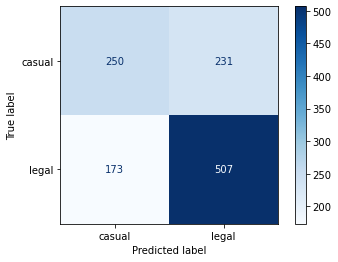

In [33]:
# Plot confusion matrix.
metrics.plot_confusion_matrix(logreg, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['casual', 'legal']);

* True Negative (TN)- correctly predicted that the post IS NOT a legal advice subreddit.
* False Positive (FP)- Incorrectly predicted that the post IS a legal advice subreddit.
* False Negative ( FN)- Incorrectly predicted that the post IS NOT a legal advice subreddit.
* True Positives (TP)-correctly predicted that the post IS a legal advice subreddit. 

In [34]:
TN, FP, FN, TP = confusion_matrix(y_test, preds).ravel()

__Missclasification Rate__ - How many did the model predict incorrectly?

In [35]:
missclassification = (FP+FN)/(TN + FP+TN+FN)
missclassification

0.4469026548672566

__Specificity__- among the casual conversation subreddits (TN), how many did the model predict correctly?

In [36]:
specificity = TN / (TN + FP)
specificity

0.5197505197505198

__Sensitivity__- among the legal advice subreddits (TP), how many did the model predict correctly?

In [37]:
sensitivity = TP / (TP + FN)
sensitivity

0.7455882352941177

* Let's compare our results to the other two variations of this logistic regression model. 

__Logistic regression model using lemmatized words__

In [38]:
# Set up X and y lemmatized words
X = reddit_tvec_lemm_posts.drop(columns ='subreddit')
y = reddit_tvec_posts['subreddit']

#Train/Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

__Baseline__

In [39]:
y.value_counts(normalize = True)

1    0.583154
0    0.416846
Name: subreddit, dtype: float64

In [40]:
# Instantiate model
logreg_lemm = LogisticRegression(solver = 'newton-cg')
# Fit the model
logreg_lemm.fit(X_train, y_train)

LogisticRegression(solver='newton-cg')

In [41]:
print(f'Training Accuracy Score: {logreg_lemm.score(X_train, y_train)}')
print(f'Testing Accuracy Score: {logreg_lemm.score(X_test, y_test)}')
print(f'Cross Validation Score: {cross_val_score(logreg_lemm,X,y).mean()}')

Training Accuracy Score: 0.7242171789715599
Testing Accuracy Score: 0.7295434969853575
Cross Validation Score: 0.7233969600237555


* Increase in overall accuracy scores in comparison to the "raw" (meaning not lemmatized or stemmed text data) text data. 
* The test accuracy score is ever so slightly higher than the training score, meaning the model performs better, barely, with test (newly introduced) data. 

In [42]:
# Predictions for test set
preds = logreg_lemm.predict(X_test)

In [43]:
# Generate confusion matrix.
confusion_matrix(y_test, preds)

array([[283, 198],
       [116, 564]])

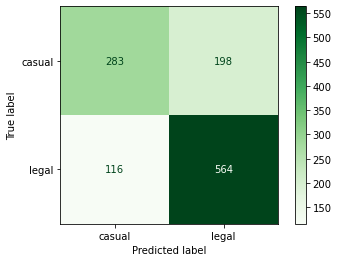

In [44]:
# Plot confusion matrix.
metrics.plot_confusion_matrix(logreg_lemm, X_test, y_test, cmap='Greens', 
                      values_format='d', display_labels=['casual', 'legal']);

In [45]:
TN, FP, FN, TP = confusion_matrix(y_test, preds).ravel()

__Misclassification Rate__ - How many did the model predict incorrectly?

In [46]:
missclassification = (FP+FN)/(TN + FP+TN+FN)
missclassification

0.3568181818181818

__Specificity__- among the casual conversation subreddits (TN), how many did the model predict correctly?

In [47]:
specificity = TN / (TN + FP)
specificity

0.5883575883575883

__Sensitivity__- among the legal advice subreddits (TP), how many did the model predict correctly?

In [48]:
sensitivity = TP / (TP + FN)
sensitivity

0.8294117647058824

__Comparison between "raw" and lemmatized text data:__
* The misclassification rate reduces, meaning less incorrect predictions
* The specificity score increase, meaning less false positives.
* The sensitivity score also increases, meaning less false negatives.  

__Logistic regression model using stemmed words__

In [49]:
# Set up X and y stemmed words
X = reddit_tvec_stem_posts.drop(columns ='subreddit')
y = reddit_tvec_posts['subreddit']

#Train/Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

__Baseline__

In [50]:
y.value_counts(normalize = True)

1    0.583154
0    0.416846
Name: subreddit, dtype: float64

In [51]:
# Instantiate model
logreg_stem = LogisticRegression(solver = 'newton-cg')
# Fit the model
logreg_stem.fit(X_train, y_train)

LogisticRegression(solver='newton-cg')

In [52]:
print(f'Training Accuracy Score: {logreg_stem.score(X_train, y_train)}')
print(f'Testing Accuracy Score: {logreg_stem.score(X_test, y_test)}')
print(f'Cross Validation Score: {cross_val_score(logreg_stem,X,y).mean()}')

Training Accuracy Score: 0.7710428037920138
Testing Accuracy Score: 0.7631352282515074
Cross Validation Score: 0.7667013102705913


* Very slight increase in scores when compared to our lemmatized model. 
* The testing model perform slightly worse than the test model. 

In [53]:
# Predictions for test set
preds = logreg_stem.predict(X_test)

In [54]:
# Generate confusion matrix.
confusion_matrix(y_test, preds)

array([[320, 161],
       [114, 566]])

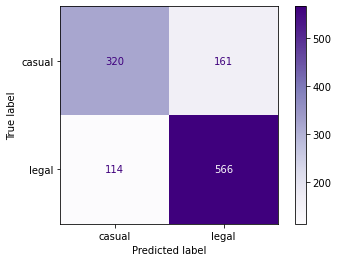

In [55]:
metrics.plot_confusion_matrix(logreg_stem, X_test, y_test, cmap='Purples', 
                      values_format='d', display_labels=['casual', 'legal']);

In [56]:
TN, FP, FN, TP = confusion_matrix(y_test, preds).ravel()

__Misclassification Rate__ - How many did the model predict incorrectly?

In [57]:
missclassification = (FP+FN)/(TN + FP+TN+FN)
missclassification

0.3005464480874317

__Specificity__- among the casual conversation subreddits (TN), how many did the model predict correctly?

In [58]:
specificity = TN / (TN + FP)
specificity

0.6652806652806653

__Sensitivity__- among the legal advice subreddits (TP), how many did the model predict correctly?

In [59]:
sensitivity = TP / (TP + FN)
sensitivity

0.8323529411764706

__Comparison between "raw" and stemmed text data:__
* The misclassification rate reduces, meaning less incorrect predictions
* The specificity score increases, meaning less false positives.
* The sensitivity score also increases, meaning less false negatives.  

__Comparison between lemmatized and stemmed text data:__
* The misclassification rate reduced by 0.056, meaninga slight decease in incorrect predictions.
* The specificity score increases (approx. 0.59 to 0.67), meaning less false positives.
* The sensitivity score also increases slightly, meaning less false negatives. 

__Logisitic Regression Summary__

Based on the accuracy scores, misclassification rate, specificity score, and sensitivity score our logistic regression model with stemmed text data, performed the best and increased our precision of proper classification of subreddit posts. 

### Random Forest Modeling

__Random Forest using raw posts__

In [60]:
#Set up X and y
X = reddit_tvec_posts.drop(columns ='subreddit')
y = reddit_tvec_posts['subreddit']

#Train/Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123, stratify=y)

In [61]:
rf = RandomForestClassifier(n_estimators=100)

In [62]:
cross_val_score(rf, X_train, y_train, cv=5).mean()

0.6426338659938324

In [63]:
#Grid Search to identify the bext parameters to use. 
rf_params = {
    'max_depth': [None, 1, 2, 3, 4, 5],
    'min_samples_leaf': [2, 3],
    'n_estimators': [100, 150, 200],
    'n_jobs': [-1]
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.6630295684295585


{'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 150, 'n_jobs': -1}

In [64]:
gs.score(X_train, y_train)

0.6931916116058604

__Random Forest using lemmatized posts__

In [65]:
#Set up X and y
X_lemm = reddit_tvec_lemm_posts.drop(columns ='subreddit')
y_lemm = reddit_tvec_posts['subreddit']

#Train/Split 
X_train, X_test, y_train, y_test = train_test_split(X_lemm, y_lemm, random_state = 123, stratify=y)

In [66]:
rf = RandomForestClassifier(n_estimators=100)

In [67]:
cross_val_score(rf, X_train, y_train, cv=5).mean()

0.7000902884282392

In [68]:
#Grid Search to identify the bext parameters to use. 
rf_params = {
    'max_depth': [None, 1, 2, 3, 4, 5],
    'min_samples_leaf': [2, 3],
    'n_estimators': [100, 150, 200],
    'n_jobs': [-1]
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.7115857781295867


{'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 200, 'n_jobs': -1}

In [69]:
gs.score(X_train, y_train)

0.7426027003734559

__Random Forest using stemmed posts__

In [70]:
#Set up X and y
X_stem = reddit_tvec_stem_posts.drop(columns ='subreddit')
y_stem = reddit_tvec_posts['subreddit']

#Train/Split 
X_train, X_test, y_train, y_test = train_test_split(X_stem, y_stem, random_state = 123, stratify=y)

In [71]:
rf = RandomForestClassifier(n_estimators=100)

In [72]:
cross_val_score(rf, X_train, y_train, cv=5).mean()

0.7655910387704283

In [73]:
#Grid Search to identify the bext parameters to use. 
rf_params = {
    'max_depth': [None, 1, 2, 3, 4, 5],
    'min_samples_leaf': [2, 3],
    'n_estimators': [100, 150, 200],
    'n_jobs': [-1]
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.7673168258051749


{'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 150, 'n_jobs': -1}

* Based on the results of this GridSearch above, the best model should include the following parameters:
        - number of estimators/the number of trees in the forest = 150
        - The maximum depth of the tree = None

In [74]:
gs.score(X_train, y_train)

0.9284688307957484

__RF Summary__

Based on the accuracy scores, our RF  model with stemmed text data, performed the best and increased our precision of properly classifying our subreddit posts. 

### Overall Summary

* Out of the two models used, the Random Forest model yielded the best results. 
* Our stemmed words resulted in a higher accuracy score compared to the lemmatized words, score of 0.96 compared to 0.74.
* For both models used it's evident the benefits of pre-peocessing the text data, either lemmatizing of stemming, in order to improve our model accuracy. 